# Goal

The goal of notebook is to experiment with using a MLP Neural Network to model an unknown function. Data will be generated with the function, and have noise added to loosely simulate experimental data. These noisy data points will then be partitoned into testing and training data for the network.

While the main goal of this is experimentation and learning, this technique may be useful in the case where a user has a data set governed by an unknown function. This technique can be used to model the unknown function, so it can be used on new data, or further analyzed.

# What this isn't

This notebook is not indended to explain the innter workings of Tensorflow, nor is it indended to be used by anyone unfamiliar with Multilayer Perception Neural Networks. This is an example use of Tensorflow Neural Networks to solve a general problem.

In [3]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from IPython import display

In [24]:
training_epochs = 3500
display_step = training_epochs*0.1
make_epoch_plots = 0
num_examples = 5000
test_fraction = 0.75

#### Use a set seed to make things easily repeatable

In [5]:
np.random.seed(1000)

### Test Functions

Return whatever you like from f(x). In place currently is a 'chirp' function for demonstration of the form: `A*sin(w(t)*t)`, where `w(t) = 2*pi*t`

In [6]:
def w(x):
    return 2.0*np.pi*x

def f(x):
#     return np.sin(x) + 0.1*np.random.randn(*x.shape)
#     return np.cos(x/np.pi)
#     return np.cos(x) + np.sin(x/np.pi)
    return np.sin( w(x)*x/1.5 )+ 0.1*np.random.randn(*x.shape)

In [14]:
n_input = 1
hidden_nodes = 50
n_hidden_0 = hidden_nodes
n_hidden_1 = hidden_nodes
n_hidden_2 = hidden_nodes
n_hidden_3 = hidden_nodes
n_hidden_4 = hidden_nodes
n_hidden_5 = hidden_nodes
n_hidden_6 = hidden_nodes

num_of_hidden_layers = 7
n_output = n_input

### X data generation

Generate equally spaced x data and plot example function values

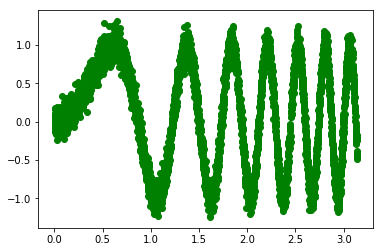

In [15]:
all_x = np.random.uniform(0*np.pi, np.pi, (1, num_examples)).T
plt.scatter(all_x, f(all_x), c='g')

### Training/Testing Set Creation

Create shuffled data. Split into training and testing sets based on the `test_fraction` value

In [16]:
np.random.shuffle(all_x)
train_size = int(num_examples*test_fraction)

# Partition data
x_training = all_x[:train_size]
x_testing = all_x[train_size:]
y_training = f(x_training)
y_testing = f(x_testing)

### Generated data plotting

Plot test and training data for visual inspection

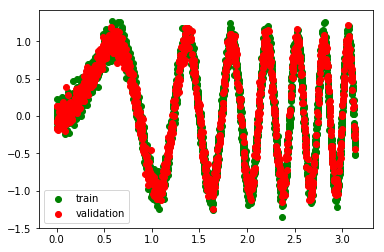

In [17]:
plt.figure(1)
plt.scatter(x_training, y_training, c='green', label='train')
plt.scatter(x_testing, y_testing, c='red', label='validation')
plt.legend()

In [18]:
tf.reset_default_graph()

### Graph Creation

Create a network with 7 hidden layers. This number is chosen only for example. Depending on the chosen f(x), additional or fewer layers may be needed. similarily the number of nodes in each layer can be tuned for specific choices of functions.

The NN function function takes an input tensor and number of hidden layers. It will then use the weight tensors defined in `weights`, and use biases defined in `biases`.

In [19]:
X = tf.placeholder("float", [None, n_input], name='X')
Y = tf.placeholder("float", [None, n_output], name='Y')


weights = {
    'h0': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h1': tf.Variable(tf.random_normal([n_hidden_0, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4])),
    'h5': tf.Variable(tf.random_normal([n_hidden_4, n_hidden_5])),
    'h6': tf.Variable(tf.random_normal([n_hidden_5, n_hidden_6])),
    'out': tf.Variable(tf.random_normal([n_hidden_6, n_output])),
}

biases = {
    'h0': tf.Variable(tf.random_normal([n_hidden_0])),
    'h1': tf.Variable(tf.random_normal([n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_3])),
    'h4': tf.Variable(tf.random_normal([n_hidden_4])),
    'h5': tf.Variable(tf.random_normal([n_hidden_5])),
    'h6': tf.Variable(tf.random_normal([n_hidden_6])),
    'out': tf.Variable(tf.random_normal([n_output])),
}


def NN(input_layer, n):
    '''
        x: Input Tensor
        n: number of hidden layers to build
        
        Returns: output layer
        
        Builds a network starting with `input_layer`, containing n hidden
        layers, and returns `output` layer.
    '''
    def __build_hidden(inpt_layer, n):
        # Layer Number counter
        ln = 0
        layer = tf.nn.sigmoid(
                tf.add(
                    tf.matmul(
                        inpt_layer, weights['h%d'%(ln)],
                        name='layer%d'%(ln)
                    ),
                    biases['h%d'%(ln)]
                )
            )
        # Increment Layer Number
        ln += 1
        while ln < n:
            layer = tf.nn.sigmoid(
                tf.add(
                    tf.matmul(
                        layer, weights['h%d'%(ln)],
                        name='layer%d'%(ln)
                    ),
                    biases['h%d'%(ln)]
                )
            )
            ln += 1
        return layer        
    
    
    layer = __build_hidden(input_layer, n)
    
    output = tf.add(
                tf.matmul(
                    layer, weights['out'],
                    name="out"
                ),
                biases['out']
            )
    return output


### Network and Training Optimizer Initialization

Build Neural Network using `NN()` function. Create cost function, and link optimizer.

In [20]:
output = NN(X, num_of_hidden_layers)
cost = tf.reduce_mean(tf.pow(output - Y, 2))
optimizer = tf.train.AdamOptimizer().minimize(tf.nn.l2_loss(output - Y))

In [21]:
init = tf.global_variables_initializer()

In [22]:
sess = tf.InteractiveSession()

### Training

Train network on training set. Track network error on validation set as well as test set. At marked epoches, print the current cost, and plot the networks best ability to model the data. This plotting makes the training *much* slower. Setting the `make_epoch_plots` condition is an easy way to enable/disable it.

In [23]:
costs = []
epoches = []
total_error = []
sess.run(init)

for epoch in range(training_epochs):
    _, c = sess.run(
        [ optimizer, cost ],
        feed_dict={
            X:x_training,
            Y:y_training
        }
    )


    costs.append(c)
    epoches.append(epoch)
    
    mse = sess.run(tf.nn.l2_loss(output - y_testing),  feed_dict={X:x_testing})
    total_error.append(mse)

    
    
    if epoch%display_step == 0:
        print('Epoch: %03d\tCost: %.9f'%(epoch, c))

        if make_epoch_plots:
            fig = plt.figure(figsize=(20,8))
            plt.scatter( x_testing, y_testing, color='g')
            plt.scatter( x_testing, sess.run(output, feed_dict={X: x_testing}), color='r')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.show()
            # Uncomment the following line to save images
            # fig.savefig("%4d_training_plot.jpg"%(epoch))

    
print('Epoch: %03d\tMSE: %.4e'%(epoch+1, c))
print('Training complete!')



Epoch: 000	Cost: 16.209127426
Epoch: 350	Cost: 0.363540649
Epoch: 700	Cost: 0.275665879
Epoch: 1050	Cost: 0.189253241
Epoch: 1400	Cost: 0.124012671
Epoch: 1750	Cost: 0.091503061
Epoch: 2100	Cost: 0.078343019
Epoch: 2450	Cost: 0.069437355
Epoch: 2800	Cost: 0.028813519
Epoch: 3150	Cost: 0.017118715
Epoch: 3500	MSE: 9.9796e-03
Training complete!


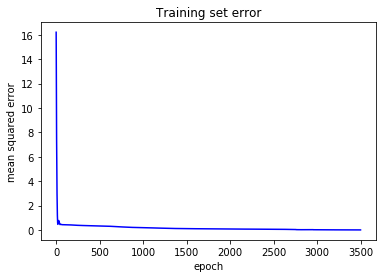

In [25]:
plt.plot( epoches, costs, 'b' )
plt.title('Training set error')
plt.xlabel('epoch')
plt.ylabel('mean squared error')
plt.show()

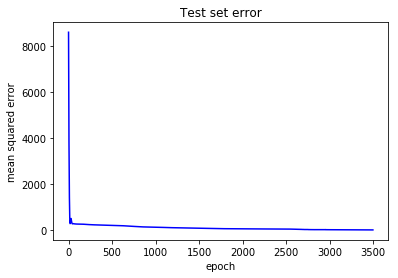

In [26]:
plt.plot( epoches, total_error, 'b' )
plt.title('Test set error')
plt.xlabel('epoch')
plt.ylabel('mean squared error')
plt.show()

### Model Prediction

Plot the model across all data, overalyed with original data.

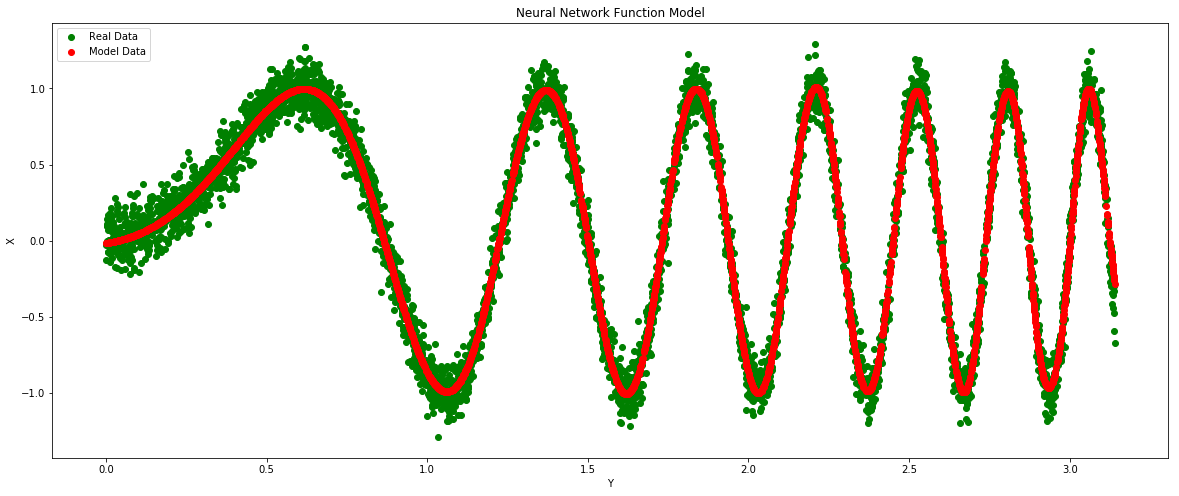

In [27]:
fig = plt.figure(figsize=(20,8))
plt.title('Neural Network Function Model')
plt.xlabel('Y')
plt.ylabel('X')
plt.scatter( all_x, f(all_x), color='g', label='Real Data')
plt.scatter( all_x, sess.run(output, feed_dict={X: all_x}), color='r', label='Model Data')
plt.legend()


plt.show()

### Conclusion

This model is able to fit the chirp function well. The network does start to have trouble as the frequency increases too much. This can be viewed by removing the period modifier in the original function `f(x)`.